In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Strategy for one stock

In [2]:
from TechnicalIndicators import *
import random 

random.seed(1)

In [16]:
# reading the data
tic = '1334 JT'
data = pd.read_csv("tickers/" + tic + ".csv", sep = ",")
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')  
data = data.set_index('date')
data.drop(["ticker"], axis = 1, inplace = True)
data.head(), data.tail()

(                last   volume
 date                         
 2013-01-04  147.8887  1553000
 2013-01-07  144.9890  1419000
 2013-01-08  144.9890   869000
 2013-01-09  144.9890   654000
 2013-01-10  144.9890   661000,
                 last    volume
 date                          
 2014-03-19  169.9471   1792000
 2014-03-20  167.9824   1277000
 2014-03-24  169.9471   1902000
 2014-03-25  169.9471   2077000
 2014-03-26  167.0000  18170000)

### Calculate daily returns

In [17]:
data['daily_returns'] = np.log(data['last']/data['last'].shift(1))
data.head(3)

,last,volume,daily_returns
date,,,
2013-01-04,147.8887,1553000,NaN
2013-01-07,144.9890,1419000,-0.019802
2013-01-08,144.9890,869000,0.000000


### Create strategy-based data columns

In [18]:
# Add techinical indicators as features
data['MA10'] = moving_average(data,10)
data['MA20'] = moving_average(data,20)
data['TMA10'] = triangular_moving_average(data,10)
data['TMA20'] = triangular_moving_average(data,20)
data['Momentum 10']= momentum(data,10)
data['Momentum 20']= momentum(data,20)
data = bollinger_bands(data, moving_average, 20)  # 20 days
data['Rate of Change(ROC-10days)'] = rate_of_change(data, 10)
data['Rate of Change(ROC-20days)'] = rate_of_change(data, 20)
data = macd(data)

In [19]:
data

,last,volume,daily_returns,MA10,MA20,TMA10,TMA20,Momentum 10,Momentum 20,20sd,upper_band,lower_band,Rate of Change(ROC-10days),Rate of Change(ROC-20days),MACD
date,,,,,,,,,,,,,,,
2013-01-04,147.8887,1553000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2013-01-07,144.9890,1419000,-0.019802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.065057
2013-01-08,144.9890,869000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.082896
2013-01-09,144.9890,654000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.088978
2013-01-10,144.9890,661000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.090409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-19,169.9471,1792000,0.005797,170.34002,171.076785,171.175020,171.037491,0.9824,0.0000,1.865928,174.808640,167.344930,-1.142853,0.581423,-0.873808
2014-03-20,167.9824,1277000,-0.011628,169.94708,171.027670,170.958902,171.059595,-3.9294,-0.9823,1.936058,174.899786,167.155554,-2.285707,-2.285707,-0.979922
2014-03-24,169.9471,1902000,0.011628,169.75061,170.929435,170.723137,171.086610,-1.9647,-1.9647,1.938679,174.806793,167.052077,-0.574682,-2.259880,-0.895164


### Create strategy indicators

In [20]:
# BUY condition
data['signal'] = np.where((data['last'] < data['lower_band']) &
                        (data['last'].shift(1) >=       data['lower_band']),1,0)

# SELL condition
data['signal'] = np.where( (data['last'] > data['upper_band']) &
                          (data['last'].shift(1) <= data['upper_band']),-1,data['signal'])
# creating long and short positions 
data['position'] = data['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
data['position'] = data['position'].shift(1)

# calculating stretegy returns
data['strategy_returns'] = data['daily_returns'] * (data['position'])

data.tail(5)

,last,volume,daily_returns,MA10,MA20,TMA10,TMA20,Momentum 10,Momentum 20,20sd,upper_band,lower_band,Rate of Change(ROC-10days),Rate of Change(ROC-20days),MACD,signal,position,strategy_returns
date,,,,,,,,,,,,,,,,,,
2014-03-19,169.9471,1792000,0.005797,170.34002,171.076785,171.175020,171.037491,0.9824,0.0000,1.865928,174.808640,167.344930,-1.142853,0.581423,-0.873808,0,1.0,0.005797
2014-03-20,167.9824,1277000,-0.011628,169.94708,171.027670,170.958902,171.059595,-3.9294,-0.9823,1.936058,174.899786,167.155554,-2.285707,-2.285707,-0.979922,0,1.0,-0.011628
2014-03-24,169.9471,1902000,0.011628,169.75061,170.929435,170.723137,171.086610,-1.9647,-1.9647,1.938679,174.806793,167.052077,-0.574682,-2.259880,-0.895164,0,1.0,0.011628
2014-03-25,169.9471,2077000,0.000000,169.65238,170.732965,170.507020,171.103801,-0.9823,-3.9294,1.819758,174.372480,167.093450,-1.704512,-2.259880,-0.818557,0,1.0,0.000000
2014-03-26,167.0000,18170000,-0.017493,169.06297,170.389140,170.241786,171.103801,-5.8941,-6.8765,1.844019,174.077178,166.701102,-1.734128,-3.954819,-0.984305,0,1.0,-0.017493


### Create signals and positions

Buy and hold returns: 0.12153384859384034
Strategy returns: 0.33863478203400865


<Axes: xlabel='date'>

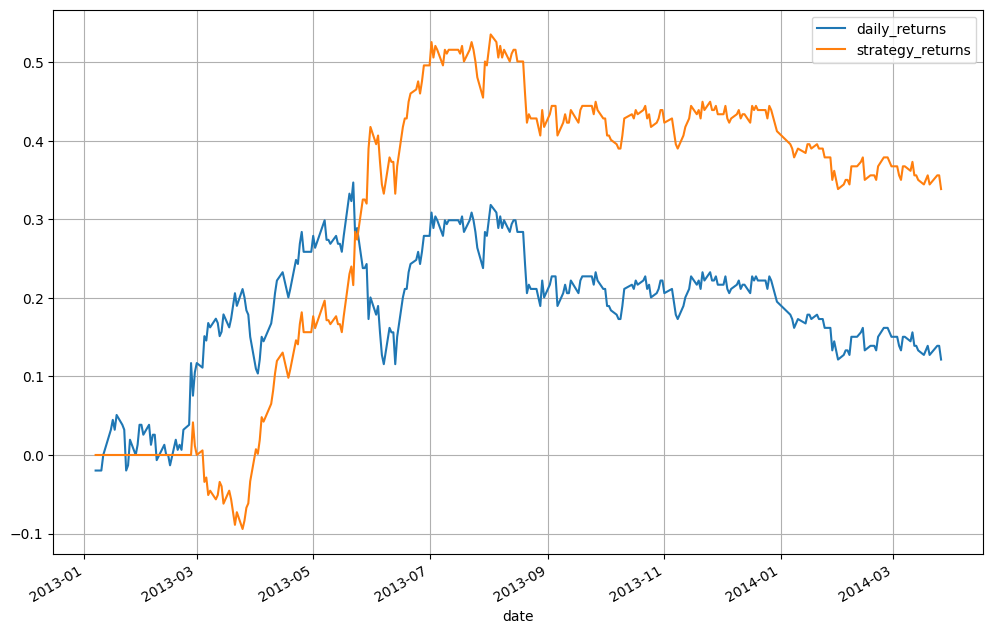

In [21]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",data['daily_returns'].cumsum()[-1])
print("Strategy returns:",data['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
data[['daily_returns','strategy_returns']] = data[['daily_returns','strategy_returns']].cumsum()
data[['daily_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))